## Try to find similarities in regions across subjects

In [4]:
# print("ok")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy    as np
import pandas   as pd
import os
import nibabel as nib
from os.path import join as opj

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nsdcode.nsd_mapdata import NSDmapdata
from nsdcode.nsd_datalocation import nsd_datalocation
from nsdcode.nsd_output import nsd_write_fs
from nsdcode.utils import makeimagestack
import nilearn
import nibabel as nib
from nilearn.image import resample_to_img
from nilearn.image import mean_img
from nilearn import plotting
import glob
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler, RobustScaler
from decoding import *


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
def compute_dice_iou(pred, ref):
    # Load the predicted and reference masks
    pred_img = pred.get_fdata().squeeze()
    ref_img = ref.get_fdata().squeeze()
    
    # # Binarize the masks
    # pred_img = (pred_img > 0).astype(np.uint8)
    # ref_img = (ref_img > 0).astype(np.uint8)

    # Compute Dice coefficient
    intersection = np.sum(pred_img * ref_img)
    dice = (2. * intersection) / (np.sum(pred_img) + np.sum(ref_img))
    
    # Compute IoU
    union = np.sum(np.logical_or(pred_img, ref_img))
    iou = intersection / union

    return dice, iou

In [4]:
source_idx=2
target_idx=1

source_test_data=f"/home/matteo/data/NSD/processed_roi/subj0{source_idx}/MNI/nsd_test_fmriavg_nsdgeneral_sub{source_idx}.npy"
source_train_data=f"/home/matteo/data/NSD/processed_roi/subj0{source_idx}/MNI/nsd_train_fmriavg_nsdgeneral_sub{source_idx}.npy"
source_test_imgs=f"/home/matteo/data/NSD/processed_roi/subj0{source_idx}/MNI/nsd_test_stim_sub{source_idx}.npy"

target_test_data=f"/home/matteo/data/NSD/processed_roi/subj0{target_idx}/MNI/nsd_test_fmriavg_nsdgeneral_sub{target_idx}.npy"


In [5]:
source_test=np.load(source_test_data)
source_train=np.load(source_train_data)


target_test=np.load(target_test_data)

## Remove useful indices 
indices=[25,31,68,121,126,318,384,492,531,606,702,860]

indices2=[70,116,165,261,278,363,451,774]
indices3=[41,205,230,411,428,446,502,777]
extra=[95,905]
comparison_indices=indices+indices2+indices3+extra

align_indices=[i for i in  range(len(source_test)) if i not in comparison_indices]

comparison_source=source_test[comparison_indices]

## keep only align indices
source_test=source_test[align_indices]
target_test=target_test[align_indices]

In [6]:
from sklearn.linear_model import RidgeCV


aligner=RidgeCV(alphas=[1e2,1e3,1e4,5e4], fit_intercept=True)
aligner.fit(source_test,target_test)

RidgeCV(alphas=[100.0, 1000.0, 10000.0, 50000.0])

In [7]:
aligner.alpha_

50000.0

## Load ROI of target subject

In [9]:
subj_path=opj("/home/matteo/explore_NSD_MNI","models",f"subj0{target_idx}")

mean=torch.load(opj(subj_path,"train_fmri_mean.pt"))
std=torch.load(opj(subj_path,"train_fmri_std.pt"))

In [10]:
standard_space="/home/matteo/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz"

In [11]:
nib.load(standard_space)

In [12]:

img_mean=mean_img([i for i in glob.glob(opj(f"/home/matteo/data/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_assumehrf","*.nii.gz")) if "betas" in i][0])
data=img_mean.get_fdata()
base_path="/home/matteo/data/NSD/"

roi_path=opj("/home/matteo/data/NSD/","nsddata","ppdata","subj01","func1pt8mm","roi")

rois=["prf-visualrois.nii.gz",
"floc-faces.nii.gz",
"floc-places.nii.gz",
"floc-words.nii.gz",
"lh.floc-bodies.nii.gz",   
"lh.floc-faces.nii.gz",       
"lh.floc-places.nii.gz",   
"lh.floc-words.nii.gz",   
"lh.prf-visualrois.nii.gz",
"rh.floc-bodies.nii.gz",   
"rh.floc-faces.nii.gz",       
"rh.floc-places.nii.gz",   
"rh.floc-words.nii.gz",   
"rh.prf-visualrois.nii.gz"]

subrois={"floc-bodies": ["EBA","FBA-1","FBA-2","mTL-bodies"],
         "floc-faces" : ["OFA","FFA-1","FFA-2","mTL-faces","aTL-faces"],
         "floc-places" : ["OPA","PPA","RSC"],
         "floc-words" : ["OVWFA", "VWFA-1","VWFA-2","msf-words","mTL-words"],
         "prf-visualrois":["V1d","V1v","V2d","V2v","V3d","V3v","hV4"],
        }

for r in rois:

    # initiate NSDmapdata
    nsd = NSDmapdata(base_path)

    sourcespace = 'func1pt8'
    sourcedata = opj(roi_path,r)
    targetspace = 'MNI'
    targetdata = nsd.fit(
        target_idx,
        sourcespace,
        targetspace,
        sourcedata,
        interptype='nearest',
        badval=0,
        outputfile=f'rois/roi_subj{target_idx}_{r}')

    test_res=nilearn.image.resample_to_img(nib.load(f'rois/roi_subj{target_idx}_{r}'), nib.load(standard_space),interpolation="nearest")


# rois={}
# roi_names=[]
# roi_corr=[]
# roi_corr_std=[]
# cmap=corr_map.get_fdata()
# for roi in tqdm.tqdm(subrois.keys()):
    
#     roi_img=nib.load(opj(roi_path,f"{roi}.nii.gz")).get_fdata()
    
#     for i,subroi in enumerate(subrois[roi]):
    
#         roi_name=subroi
#         roi_names.append(roi_name)
#         rois[roi_name]=nib.Nifti1Image((roi_img==i+1)*1., affine=img_mean.affine)

saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space


## Warp target subject to MNI

In [13]:

img_mean=mean_img([i for i in glob.glob(opj(f"/home/matteo/data/NSD/nsddata_betas/ppdata/subj0{source_idx}/func1pt8mm/betas_assumehrf","*.nii.gz")) if "betas" in i][0])
data=img_mean.get_fdata()

roi_path=opj(base_path,"nsddata","ppdata",f"subj0{source_idx}","func1pt8mm","roi")

rois=["prf-visualrois.nii.gz",
"floc-faces.nii.gz",
"floc-places.nii.gz",
"floc-words.nii.gz",
"lh.floc-bodies.nii.gz",   
"lh.floc-faces.nii.gz",       
"lh.floc-places.nii.gz",   
"lh.floc-words.nii.gz",   
"lh.prf-visualrois.nii.gz",
"rh.floc-bodies.nii.gz",   
"rh.floc-faces.nii.gz",       
"rh.floc-places.nii.gz",   
"rh.floc-words.nii.gz",   
"rh.prf-visualrois.nii.gz"]

subrois={"floc-bodies": ["EBA","FBA-1","FBA-2","mTL-bodies"],
         "floc-faces" : ["OFA","FFA-1","FFA-2","mTL-faces","aTL-faces"],
         "floc-places" : ["OPA","PPA","RSC"],
         "floc-words" : ["OVWFA", "VWFA-1","VWFA-2","msf-words","mTL-words"],
         "prf-visualrois":["V1d","V1v","V2d","V2v","V3d","V3v","hV4"],
        }

for r in rois:

    # initiate NSDmapdata
    nsd = NSDmapdata(base_path)

    sourcespace = 'func1pt8'
    sourcedata = opj(roi_path,r)
    targetspace = 'MNI'
    targetdata = nsd.fit(
        source_idx,
        sourcespace,
        targetspace,
        sourcedata,
        interptype='nearest',
        badval=0,
        outputfile=f'rois/roi_subj{source_idx}_{r}')

    test_res=nilearn.image.resample_to_img(nib.load(f'rois/roi_subj{source_idx}_{r}'), nib.load(standard_space),interpolation="nearest")
    


saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space
saving image in MNI space


## Load ROI of target and source subjects

select subrois here!

In [14]:
## Load NSDGeneral ROI





nsd_roi=nib.load(f"/home/matteo/data/NSD/nsddata/ppdata/subj0{target_idx}/MNI/nsdgeneral_mni.nii.gz")
# nsd_roi=nilearn.image.binarize_img(nsd_roi,threshold=0.1, mask_img=None)
nsd_roi= nilearn.image.math_img("img > 0" , img=nsd_roi)

In [15]:
subrois={"floc-bodies": ["EBA","FBA-1","FBA-2","mTL-bodies"],
         "floc-faces" : ["OFA","FFA-1","FFA-2","mTL-faces","aTL-faces"],
         "floc-places" : ["OPA","PPA","RSC"],
         "floc-words" : ["OVWFA", "VWFA-1","VWFA-2","msf-words","mTL-words"],
         "prf-visualrois":["V1d","V1v","V2d","V2v","V3d","V3v","hV4"],
        }

#try FFA

roi_selected="floc-places"
subroi="PPA"
subroi_idx=np.where(np.array(subrois[roi_selected])==subroi)[0][0]+1
print(subroi_idx)


target_visual_roi=nib.load(f"rois/roi_subj{target_idx}_{roi_selected}.nii.gz")
source_visual_roi=nib.load(f"rois/roi_subj{source_idx}_{roi_selected}.nii.gz")



2


In [16]:
target_visual_roi=nilearn.image.resample_to_img(target_visual_roi, nib.load(standard_space),interpolation="nearest")
source_visual_roi=nilearn.image.resample_to_img(source_visual_roi, nib.load(standard_space),interpolation="nearest")


In [17]:
## keep only voxels of selected subroi
whole_roi=True
if not whole_roi:

    target_visual_roi=nib.Nifti1Image(1.*(target_visual_roi.get_fdata()==subroi_idx),affine=target_visual_roi.affine)
    source_visual_roi=nib.Nifti1Image(1.*(source_visual_roi.get_fdata()==subroi_idx),affine=source_visual_roi.affine)
else:
    target_visual_roi=nib.Nifti1Image(1.*(target_visual_roi.get_fdata()>0),affine=target_visual_roi.affine)
    source_visual_roi=nib.Nifti1Image(1.*(source_visual_roi.get_fdata()>0),affine=source_visual_roi.affine)

    

In [18]:
target_visual_roi.affine, nsd_roi.affine, nib.load(standard_space).affine

(array([[  -2.,    0.,    0.,   90.],
        [   0.,    2.,    0., -126.],
        [   0.,    0.,    2.,  -72.],
        [   0.,    0.,    0.,    1.]]),
 array([[  -2.,    0.,    0.,   90.],
        [   0.,    2.,    0., -126.],
        [   0.,    0.,    2.,  -72.],
        [   0.,    0.,    0.,    1.]]),
 array([[  -2.,    0.,    0.,   90.],
        [   0.,    2.,    0., -126.],
        [   0.,    0.,    2.,  -72.],
        [   0.,    0.,    0.,    1.]]))

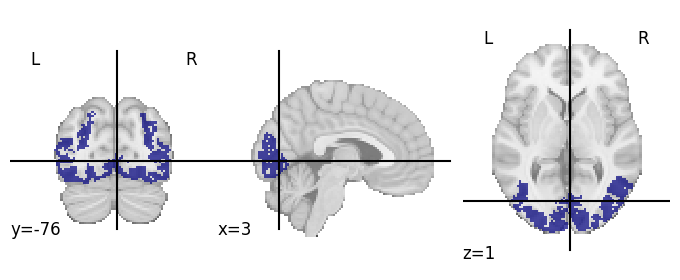

In [19]:
nilearn.plotting.plot_roi(nsd_roi)

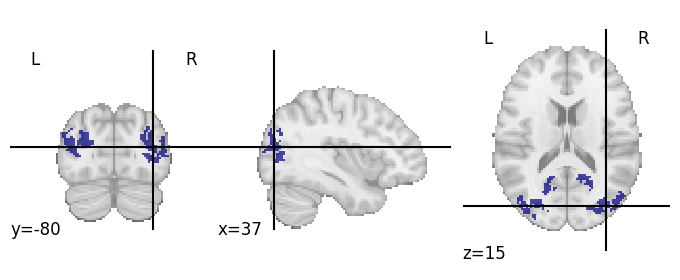

In [20]:
a=nilearn.plotting.plot_roi(target_visual_roi)
a

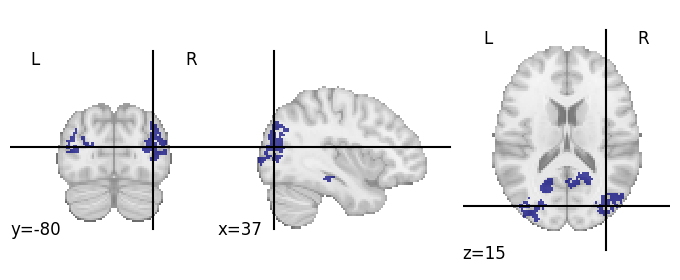

In [21]:
nilearn.plotting.plot_roi(source_visual_roi,cut_coords=a.cut_coords)

In [22]:
masker=NiftiMasker(mask_img=nsd_roi)
source_visual_voxels=masker.fit_transform(source_visual_roi)

In [25]:
source_visual_aligned=aligner.predict(source_visual_voxels)
source_visual_aligned=(source_visual_aligned-mean.numpy())/std.numpy()
source_visual_aligned=np.nan_to_num(source_visual_aligned,0)

/tmp/ipykernel_3524933/4235316668.py:2: RuntimeWarning: invalid value encountered in divide
  source_visual_aligned=(source_visual_aligned-mean.numpy())/std.numpy()


In [31]:
# std=RobustScaler()

# source_visual_aligned=std.fit_transform(source_visual_aligned.T).T

In [26]:
source_visual_aligned

array([[-0.28118184,  0.1642445 ,  0.29486277, ...,  0.58983926,
         0.        ,  0.        ]])

In [27]:
source_visual_aligned_img=masker.inverse_transform(source_visual_aligned)

-0.06415972517184945

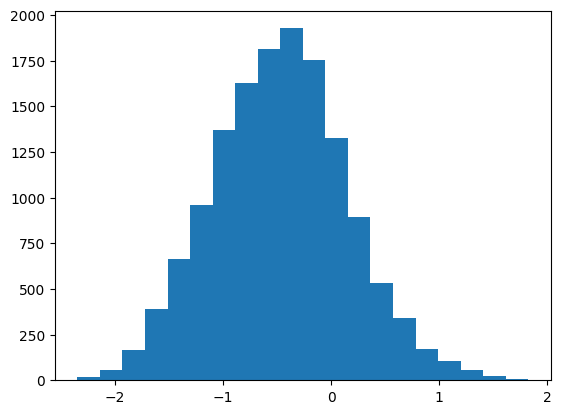

In [28]:
plt.hist(source_visual_aligned.flatten(),bins=20)

np.percentile(source_visual_aligned,75)

In [2]:
# print("Ok")

In [29]:
source_visual_aligned_smooth_img = nilearn.image.smooth_img(source_visual_aligned_img, 3)

In [40]:
source_visual_roi=nilearn.image.math_img('img1*img2',img1=source_visual_roi,img2=nsd_roi)
target_visual_roi=nilearn.image.math_img('img1*img2',img1=target_visual_roi,img2=nsd_roi)


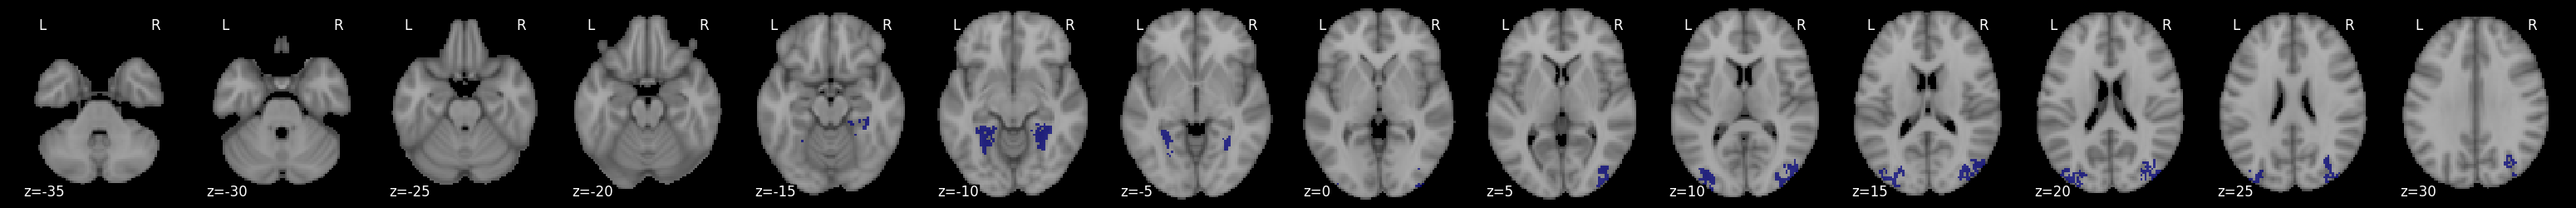

In [44]:
nilearn.plotting.plot_roi(source_visual_roi, display_mode="z", bg_img=standard_space,cut_coords=range(-35,35,5),black_bg=True)

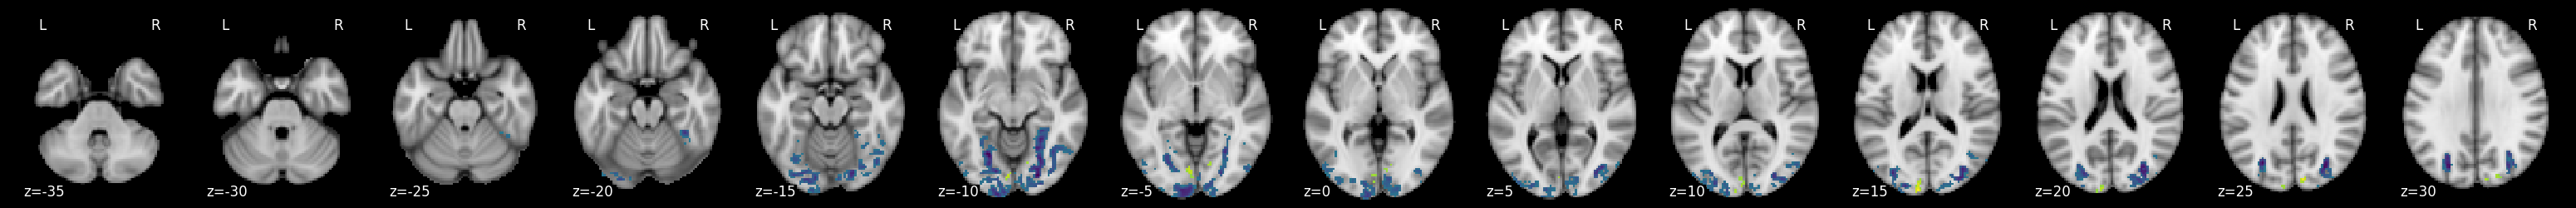

In [66]:
nilearn.plotting.plot_img(source_visual_aligned_smooth_img, threshold=.6,display_mode="z", bg_img=standard_space,cut_coords=range(-35,35,5),black_bg=True)

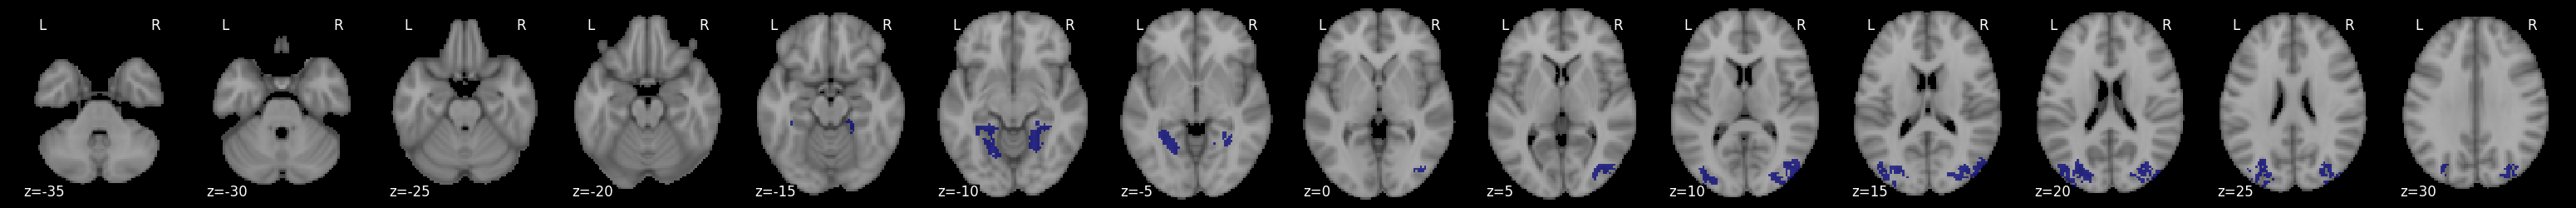

In [42]:
nilearn.plotting.plot_roi(target_visual_roi,display_mode="z", cut_coords=range(-35,35,5),bg_img=standard_space,black_bg=True)

In [56]:
# source_visual_aligned_smooth_img.get_fdata().max()

In [73]:
metrics={}
metrics["aligned-source"]={"dice":[], "iou": [] , "thr": []}
metrics["aligned-target"]={"dice":[], "iou": [] , "thr": []}

p_thresholds= np.linspace(0,1.25,10)
# thresholds=[contrast_map.get_fdata().flatten().max()*i for i in p_thresholds]
# nsd_roi=nsd_rois[name]


for thr in tqdm.tqdm(p_thresholds):
    encoded_roi=nilearn.image.threshold_img(source_visual_aligned_smooth_img,threshold=thr,cluster_threshold=10,mask_img=nsd_roi)
    encoded_roi=nilearn.image.binarize_img(encoded_roi,threshold=thr)
    # encoded_roi=nib.Nifti1Image(contrast_map.get_fdata()*(contrast_map.get_fdata()>thr),affine=contrast_map.affine)

    d,i=compute_dice_iou(encoded_roi,source_visual_roi)
    metrics["aligned-source"]["thr"].append(thr)
    metrics["aligned-source"]["dice"].append(d)
    metrics["aligned-source"]["iou"].append(i)
    
    d,i=compute_dice_iou(encoded_roi,target_visual_roi)
    metrics["aligned-target"]["thr"].append(thr)
    metrics["aligned-target"]["dice"].append(d)
    metrics["aligned-target"]["iou"].append(i)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]


In [74]:
metrics["aligned-target"]

{'dice': [0.26219892674404094,
  0.2744555320853667,
  0.2811975624834408,
  0.2730465320456541,
  0.2574173495337666,
  0.24562695636162768,
  0.22302158273381295,
  0.19325707405177603,
  0.13728323699421965,
  0.07134071340713408],
 'iou': [0.15087971274685816,
  0.15905445335584634,
  0.16360086322063508,
  0.15810879511947126,
  0.14772174477055294,
  0.14000839630562553,
  0.12550607287449392,
  0.10696434521826058,
  0.07370054305663305,
  0.036989795918367346],
 'thr': [0.0,
  0.1388888888888889,
  0.2777777777777778,
  0.4166666666666667,
  0.5555555555555556,
  0.6944444444444444,
  0.8333333333333334,
  0.9722222222222223,
  1.1111111111111112,
  1.25]}

## Experiment with decoding of aligned ROIs

In [19]:
subj_path=opj("/home/matteo/explore_NSD_MNI","models",f"subj0{target_idx}")
brain_decoder=BrainDiffuserPretrainedDecoder(subj_path=subj_path,device="cuda:0")



Loading pretrained deep learning backbones


Fetching 17 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 66638.47it/s]


Loading pretrained brain to feature models
loading brain to latent models


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


loading brain to img embeddings models
loading brain to txt embeddings models
loading adjust values
loading predicted values for adjusting


In [61]:
subrois={"floc-bodies": ["EBA","FBA-1","FBA-2","mTL-bodies"],
         "floc-faces" : ["OFA","FFA-1","FFA-2","mTL-faces","aTL-faces"],
         "floc-places" : ["OPA","PPA","RSC"],
         "floc-words" : ["OVWFA", "VWFA-1","VWFA-2","msf-words","mTL-words"],
         "prf-visualrois":["V1d","V1v","V2d","V2v","V3d","V3v","hV4"],
        }

#try FFA

roi_selected="floc-faces"
subroi="FFA-1"
subroi_idx=np.where(np.array(subrois[roi_selected])==subroi)[0][0]+1
print(subroi_idx)


target_visual_roi=nib.load(f"rois/roi_subj{target_idx}_{roi_selected}.nii.gz")
source_visual_roi=nib.load(f"rois/roi_subj{source_idx}_{roi_selected}.nii.gz")
target_visual_roi=nilearn.image.resample_to_img(target_visual_roi, nib.load(standard_space),interpolation="nearest")
source_visual_roi=nilearn.image.resample_to_img(source_visual_roi, nib.load(standard_space),interpolation="nearest")


## keep only voxels of selected subroi
whole_roi=True
if not whole_roi:

    target_visual_roi=nib.Nifti1Image(1.*(target_visual_roi.get_fdata()==subroi_idx),affine=target_visual_roi.affine)
    source_visual_roi=nib.Nifti1Image(1.*(source_visual_roi.get_fdata()==subroi_idx),affine=source_visual_roi.affine)
else:
    target_visual_roi=nib.Nifti1Image(1.*(target_visual_roi.get_fdata()>0),affine=target_visual_roi.affine)
    source_visual_roi=nib.Nifti1Image(1.*(source_visual_roi.get_fdata()>0),affine=source_visual_roi.affine)

masker=NiftiMasker(mask_img=nsd_roi)
source_visual_voxels=masker.fit_transform(source_visual_roi)
source_visual_aligned=aligner.predict(source_visual_voxels)




2


In [60]:
# mean.mean().item()

406.74388577519005

In [43]:
# src_img, gss = brain_decoder.decode(torch.tensor(source_visual_voxels).repeat(4,1))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:41<00:00,  1.87it/s]


tensor(0.8549)
[INFO] Final reconstrution 1/4


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.82it/s]


[INFO] Final reconstrution 2/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.84it/s]


[INFO] Final reconstrution 3/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.82it/s]


[INFO] Final reconstrution 4/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:38<00:00,  2.02it/s]
/home/matteo/explore_NSD_MNI/vae_helpers.py:164: RuntimeWarning: invalid value encountered in cast
  xhat = np.minimum(np.maximum(0.0, xhat), 255.0).astype(np.uint8)
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call

tensor(0.)
[INFO] Final reconstrution 1/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.84it/s]


[INFO] Final reconstrution 2/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.86it/s]


[INFO] Final reconstrution 3/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.86it/s]


[INFO] Final reconstrution 4/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.85it/s]


In [62]:
# source_visual_aligned_adj=(torch.tensor(source_visual_aligned)-mean)/std
# source_visual_aligned_adj=torch.nan_to_num(source_visual_aligned_adj)

In [63]:
# all_img, gss = brain_decoder.decode(source_visual_aligned_adj.repeat(4,1))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:13<00:00,  5.54it/s]


tensor(0.7961)
[INFO] Final reconstrution 1/4


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.83it/s]


[INFO] Final reconstrution 2/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.85it/s]


[INFO] Final reconstrution 3/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.84it/s]


[INFO] Final reconstrution 4/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.83it/s]


In [68]:

# fig,axs=plt.subplots(2,4,figsize=(8,4))

# for i in range(4):
#     axs[0,i].imshow(src_img[i])
#     axs[1,i].imshow(all_img[i])
    
# # for i,ax in enumerate(axs.ravel()):
# fig.suptitle("floc-faces comparison between subject space and aligned space using target subject decoder")

In [67]:
# source_visual_aligned_adj